In [7]:
import os 
import numpy as np
import xml.etree.ElementTree as ET
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd

dir_anno = "data/VOCdevkit/VOC2012/Annotations"
img_dir  = "data/VOCdevkit/VOC2012/JPEGImages"

## Extract image and annotation

In [8]:
def extract_single_xml_file(tree):
    Nobj = 0
    row  = OrderedDict()
    for elems in tree.iter():

        if elems.tag == "size":
            for elem in elems:
                row[elem.tag] = int(elem.text)
        if elems.tag == "object":
            for elem in elems:
                if elem.tag == "name":
                    row["bbx_{}_{}".format(Nobj,elem.tag)] = str(elem.text)              
                if elem.tag == "bndbox":
                    for k in elem:
                        row["bbx_{}_{}".format(Nobj,k.tag)] = float(k.text)
                    Nobj += 1
    row["Nobj"] = Nobj
    return(row)
    
df_anno = []
for fnm in os.listdir(dir_anno):  
    if not fnm.startswith('.'): ## do not include hidden folders/files
        tree = ET.parse(os.path.join(dir_anno,fnm))
        row = extract_single_xml_file(tree)
        row["fileID"] = fnm.split(".")[0]
        df_anno.append(row)
df_anno = pd.DataFrame(df_anno)

maxNobj = np.max(df_anno["Nobj"])

df_anno.head()

,width,height,depth,bbx_0_name,bbx_0_xmin,bbx_0_ymin,bbx_0_xmax,bbx_0_ymax,Nobj,fileID,bbx_1_name,bbx_1_xmin,bbx_1_ymin,bbx_1_xmax,bbx_1_ymax,bbx_2_name,bbx_2_xmin,bbx_2_ymin,bbx_2_xmax,bbx_2_ymax,bbx_3_name,bbx_3_xmin,bbx_3_ymin,bbx_3_xmax,bbx_3_ymax,bbx_4_name,bbx_4_xmin,bbx_4_ymin,bbx_4_xmax,bbx_4_ymax,bbx_5_name,bbx_5_xmin,bbx_5_ymin,bbx_5_xmax,bbx_5_ymax,bbx_6_name,bbx_6_xmin,bbx_6_ymin,bbx_6_xmax,bbx_6_ymax,bbx_7_name,bbx_7_xmin,bbx_7_ymin,bbx_7_xmax,bbx_7_ymax,bbx_8_name,bbx_8_xmin,bbx_8_ymin,bbx_8_xmax,bbx_8_ymax,bbx_9_name,bbx_9_xmin,bbx_9_ymin,bbx_9_xmax,bbx_9_ymax,bbx_10_name,bbx_10_xmin,bbx_10_ymin,bbx_10_xmax,bbx_10_ymax,...,bbx_44_name,bbx_44_xmin,bbx_44_ymin,bbx_44_xmax,bbx_44_ymax,bbx_45_name,bbx_45_xmin,bbx_45_ymin,bbx_45_xmax,bbx_45_ymax,bbx_46_name,bbx_46_xmin,bbx_46_ymin,bbx_46_xmax,bbx_46_ymax,bbx_47_name,bbx_47_xmin,bbx_47_ymin,bbx_47_xmax,bbx_47_ymax,bbx_48_name,bbx_48_xmin,bbx_48_ymin,bbx_48_xmax,bbx_48_ymax,bbx_49_name,bbx_49_xmin,bbx_49_ymin,bbx_49_xmax,bbx_49_ymax,bbx_50_name,bbx_50_xmin,bbx_50_ymin,bbx_50_xmax,bbx_50_ymax,bbx_51_name,bbx_51_xmin,bbx_51_ymin,bbx_51_xmax,bbx_51_ymax,bbx_52_name,bbx_52_xmin,bbx_52_ymin,bbx_52_xmax,bbx_52_ymax,bbx_53_name,bbx_53_xmin,bbx_53_ymin,bbx_53_xmax,bbx_53_ymax,bbx_54_name,bbx_54_xmin,bbx_54_ymin,bbx_54_xmax,bbx_54_ymax,bbx_55_name,bbx_55_xmin,bbx_55_ymin,bbx_55_xmax,bbx_55_ymax
0,486,500,3,person,174.0,101.0,349.0,351.0,1,2007_000027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500,281,3,aeroplane,104.0,78.0,375.0,183.0,4,2007_000032,aeroplane,133.0,88.0,197.0,123.0,person,195.0,180.0,213.0,229.0,person,26.0,189.0,44.0,238.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500,366,3,aeroplane,9.0,107.0,499.0,263.0,3,2007_000033,aeroplane,421.0,200.0,482.0,226.0,aeroplane,325.0,188.0,411.0,223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,500,375,3,tvmonitor,156.0,89.0,344.0,279.0,1,2007_000039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500,335,3,train,263.0,32.0,500.0,295.0,2,2007_000042,train,1.0,36.0,235.0,299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
labels = np.unique(df_anno.iloc[:,3])
print(tuple(labels))
print(len(labels))

('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
20


## Selective Search

On a deux selective search
- celui fournit dans la librairie cv2
- un custom dans selective_search.py

In [ ]:
import imageio
import helpers

# le selective search custom
import selective_search as ss

# celui provenant de cv2
import cv2
cv2.setUseOptimized(True)
ss2 = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


### Comparatif des deux selectives search

#### Custom

In [ ]:
fst_img_path = os.path.join(img_dir,os.listdir(img_dir)[1])
fst_img = imageio.imread(fst_img_path)
reg = ss.get_region_proposal(fst_img, min_size=50)
regions = np.array([r["rect"] for r in reg])

1624 regions


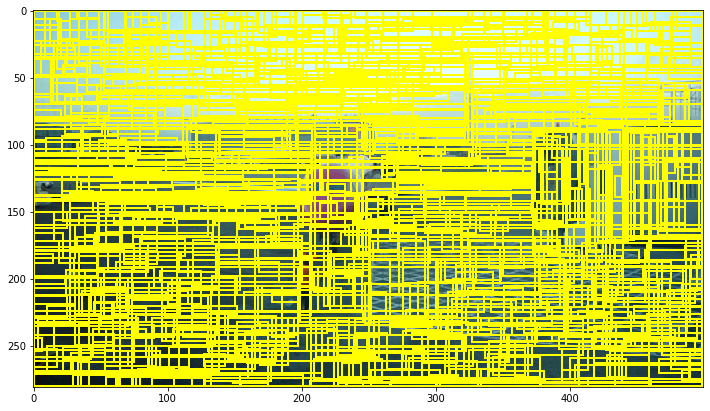

In [ ]:
print(f"{len(regions)} regions")
r = regions[0]
plt.figure(figsize=(12,12))
plt.imshow(fst_img)
for r in regions:
    helpers.plt_rectangle(plt,r[0], r[1], r[2], r[3])
plt.show()

[250 169 487 250]


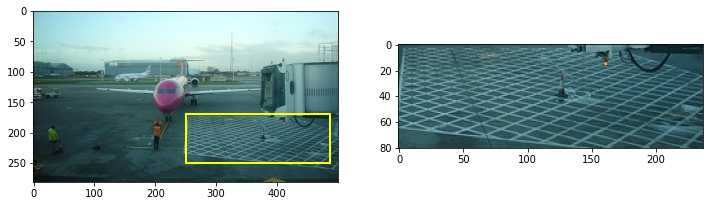

In [ ]:
aRegion = regions[1100]
print(regions[1100])
crop = np.array(fst_img[aRegion[1]:aRegion[3],aRegion[0]:aRegion[2]])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(fst_img)
helpers.plt_rectangle(plt,aRegion[0], aRegion[1], aRegion[2], aRegion[3])
plt.subplot(122)
plt.imshow(crop)
plt.show()

#### CV2

In [ ]:
ss2.setBaseImage(fst_img)
ss2.switchToSelectiveSearchQuality()
rects = ss2.process()

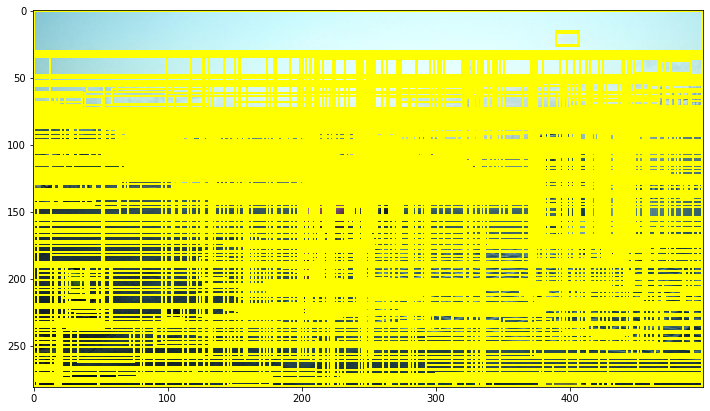

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(fst_img)
for r in rects:
    helpers.plt_rectangle(plt,r[0], r[1], r[0]+r[2]-1, r[1]+r[3]-1)
plt.show()

In [ ]:
other_img = imageio.imread(os.path.join(img_dir,"2007_000272.jpg"))
ss2.setBaseImage(other_img)
ss2.switchToSelectiveSearchQuality()
rects = ss2.process()

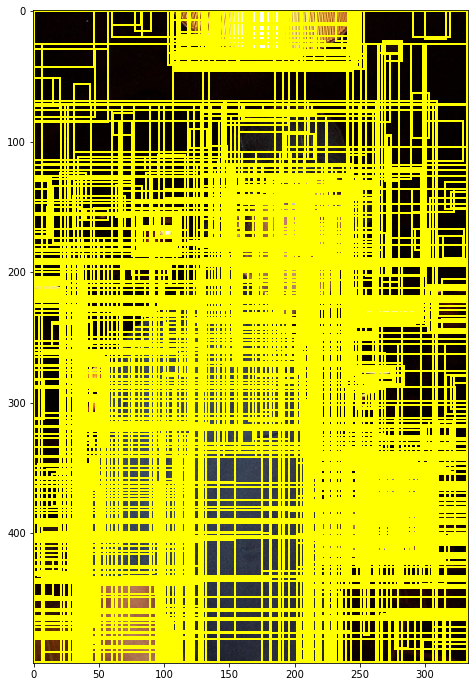

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(other_img)
for r in rects:
    helpers.plt_rectangle(plt,r[0], r[1], r[0]+r[2]-1, r[1]+r[3]-1)
plt.show()

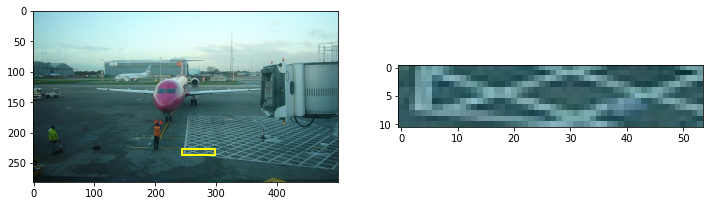

In [ ]:
aRect = rects[98]
crop = np.array(fst_img[aRect[1]:aRect[3]+aRect[1],aRect[0]:aRect[2]+aRect[0]])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(fst_img)
helpers.plt_rectangle(plt,aRect[0],aRect[1],aRect[0]+aRect[2],aRect[1]+aRect[3])
plt.subplot(122)
plt.imshow(crop)
plt.show()

## Prepare Data

In [3]:
from skimage.transform import resize 


def warp(img, newsize):
    '''
    warp image 
    
    img     : np.array of (height, width, Nchannel)
    newsize : (height, width)
    '''
    img_resize = resize(img,newsize)
    return(img_resize)

def get_image_from_anno(row=None, index_row=0, anno=None):
    if anno:
        row = anno.iloc[index_row,:]
    path = os.path.join(img_dir,row["fileID"] + ".jpg")
    img  = imageio.imread(path)
    return (img, path)

def get_true_detection_from_anno(row=None,index_row = 0, anno=None):
    true_bboxes = []
    if anno:
        row = anno.iloc[index_row,:]
    for ibb in range(row["Nobj"]):
        name = row["bbx_{}_name".format(ibb)]
        true_xmin = row["bbx_{}_xmin".format(ibb)]
        true_ymin = row["bbx_{}_ymin".format(ibb)]
        true_xmax = row["bbx_{}_xmax".format(ibb)]
        true_ymax = row["bbx_{}_ymax".format(ibb)]
        true_bboxes.append({"name": name, "rect": (true_xmin, true_ymin, true_xmax, true_ymax)})
    return true_bboxes

def get_wrapped_extracted_bbox(img, rect, size):
    """
    img     : np.array of (height, width, Nchannel)
    rect    :(xmin, ymin, xmax, ymax)
    size    :(height, width)
    """
    extract_img = np.array(img[int(rect[1]):int(rect[3]),int(rect[0]):int(rect[2])])
    warpped_img = warp(extract_img, size)
    return warpped_img

def get_vector_from_label(label):
    vector = np.zeros(21)
    if label in labels: vector[np.where(labels == label)] = 1
    else: vector[20] = 1 # no label so it's background
    return vector

Objectif associer chaque true_bbox warpped un vecteur de 21 avec un 1 pour le bon label
entrainer le vggmodel dessus
viré la dernière couche
entrainer 20 model SVM ( 1 pour chaque classe ) sur les feature map (avant dernière couche de 4097) du vgg entrainé

#### try above method on one image

Nombre de binding box: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


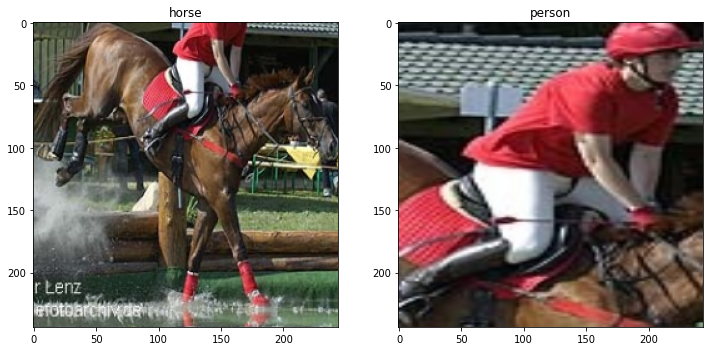

In [ ]:
row = df_anno.iloc[25]
img, _ = get_image_from_anno(row=row)
true_bboxes = get_true_detection_from_anno(row=row)
print(f"Nombre de binding box: {row['Nobj']}")
plt.figure(figsize=(12,12))
i = 1
for bbox in true_bboxes:
    plt.subplot(int(f"1{len(true_bboxes)}{i}"))
    bbox_img = get_wrapped_extracted_bbox(img,bbox['rect'],(244,244)) 
    vector = get_vector_from_label(bbox['name'])
    print(vector)
    plt.title(bbox['name'])
    plt.imshow(bbox_img)
    i += 1

#### Extract all

In [ ]:
import time 

def save_array(array, path):
    np_array = np.array(array)
    np.save(path, np_array)
    
def extract_data_for_training(
    i_min,
    i_max,
    selective_search = "cv2",
    iou_background = 0.05, 
    iou_object = 0.8, 
    nb_object_max = 15, 
    nb_background_max = 2 ):

    x_train = []  # ttbox of img_shape
    x_train_info = []
    y_train = []  # 21 values vector identify class
    
    save_dir = "data/training_dataset"
    img_shape = (224,224) # shape of the inpout layer

    step = 85
    start_time = time.time()
    for i in range(i_min,i_max):
        row = df_anno.iloc[i]

        #verbose
        if i_max-i_min > step and (i-i_min) % int(min(df_anno.shape[0],i_max)/step) == 0:
            l = int(round((i-i_min)/min(df_anno.shape[0],i_max-i_min)*step))
            a = '■'*l
            b = '□'*(step-l)
            rest = '--'
            if(l!=0):
                tot = (time.time()-start_time)/l*(step-l)
                hour = int(tot//3600)
                minu = int(tot//60)
                sec = int(tot%60)
                if hour > 0: rest = f"{hour}h{minu-hour*60}"
                else: rest = f"{minu}:{sec}"
            print('\r', '['+a+b+']', str(round((i-i_min)/min(df_anno.shape[0],i_max-i_min)*100))+"%",rest,len(y_train), end='')


        img, path = get_image_from_anno(row=row)
        true_bboxes = get_true_detection_from_anno(row=row)

        if(selective_search == "cv2"):
            ss2.setBaseImage(img)
            ss2.switchToSelectiveSearchFast()
            regions = ss2.process()
        else:
            reg = ss.get_region_proposal(img, min_size=80)
            regions = np.array([r["rect"] for r in reg])

        nb_background = 0
        nb_object = 0

        # Pour une image annotée
        # Pour chaque région du selective search si elle corresponds à un objet annoté (iou proche de 1) alors je garde cette région 
        # comme contenant l'objet
        # Sinon si il elle ne correspond à aucun objets(iou proche de 0) de l'image alors je garde cette région comme back ground
        for r in regions:
            # bbox_img = get_wrapped_extracted_bbox(img,bbox['rect'],img_shape)
            if(selective_search == "cv2"):
                r[2] += r[0]
                r[3] += r[1]

            r_is_background = True

            for bbox in true_bboxes:
                iou = ss.get_IOU(*bbox["rect"], *r)
                if nb_object_max == nb_object and nb_background_max == nb_background:
                    break
                elif iou > iou_object and nb_object < nb_object_max:
                    r_img = get_wrapped_extracted_bbox(img, tuple(r), img_shape)
                    # x_train.append(r_img)
                    save_array(r_img, os.path.join(save_dir,f"x_train/{len(x_train_info)}.npy"))
                    x_train_info.append({
                        "origin_path": path,
                        "bbow_path": f"{len(x_train_info)}.npy",
                        "rect": tuple(r), 
                        "true_rect": tuple(bbox["rect"]), 
                        "iou": iou, 
                        "label": bbox["name"]})
                    y_train.append(get_vector_from_label(bbox["name"]))
                    r_is_background = False
                    nb_object += 1
                elif iou > iou_background:
                    r_is_background = False

            if nb_object_max == nb_object and nb_background_max == nb_background:
                break       
            elif r_is_background and nb_background < nb_background_max:
                r_img = get_wrapped_extracted_bbox(img, tuple(r), img_shape)
                # x_train.append(r_img)
                save_array(r_img, os.path.join(save_dir,f"x_train/{len(x_train_info)}.npy"))
                x_train_info.append({
                    "origin_path": path, 
                    "bbow_path": f"{len(x_train_info)}.npy", 
                    "rect": tuple(r), 
                    "label": 'background'})
                y_train.append(get_vector_from_label("background"))
                nb_background += 1
                


    save_array(x_train_info, os.path.join(save_dir,f"x_train_info.npy"))
    save_array(y_train, os.path.join(save_dir,f"y_train.npy"))
    return x_train_info, y_train

Bench:
i_max = 100
iou_background = 0.05
iou_object = 0.65
nb_object_max = 15
nb_background_max = 2

 - cv2 quality: 7min | y_train: 1648  |  min: pottedplant 12  |  person: 351
 - cv2 fast: 2min16 | 1444 |  min: pottedplant 12  | person: 283
 - custom:  3min45 | 1009  |  pottedplant: 5   |   person: 173


In [ ]:
def example_training_data(x_train_info, y_train):
    names = []
    for y in y_train:
        index =np.where(y == 1)[0]
        if(index == 20): names.append("background")
        else: names.append(labels[index][0])
        
    for i in np.random.randint(len(y_train), size=5):
        y = y_train[i]
        info = x_train_info[i]
        index =np.where(y == 1)[0]
        if(index == 20): 
            names.append("background")
        else:
            names.append(labels[index][0])
            img = imageio.imread(info['path'])
            plt.imshow(img)
            helpers.plt_rectangle(plt, *info['rect'])
            helpers.plt_rectangle(plt, *info['true_rect'], color="red")
            plt.show()
            print(info["iou"])
            print(info["label"])

#### Save data 

In [ ]:
x_train_info, y_train = extract_data_for_training(0,df_anno.shape[0])

 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% 0:0 128309

## Load data

In [112]:
import helpers
import numpy as np
from sklearn.model_selection import train_test_split

In [113]:
x_train_info = np.load('data/training_dataset/x_train_info.npy', allow_pickle=True)
y_train = np.load('data/training_dataset/y_train.npy')
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor', 'background']

In [114]:
def keep_part_of_data(x, y, nb_to_keep_per_class):
    indexes = np.arange(len(y))
    np.random.shuffle(indexes)

    x_kept = []
    y_kept = []
    nb_of_class = len(y[0])
    nb_per_class = np.zeros(nb_of_class)

    for i in indexes:
            a_class = np.argmax(y[i]) 
            if(nb_per_class[a_class] < nb_to_keep_per_class):
                x_kept.append(x[i]['bbow_path'])
                y_kept.append(y[i])
                nb_per_class[a_class] +=1
        
    return x_kept, y_kept


In [115]:
x_small, y_small = keep_part_of_data(x=x_train_info, y=y_train, nb_to_keep_per_class=3000)

X_train, x_val , Y_train, y_val = train_test_split(np.array(x_small),np.array(y_small),test_size=0.25)
X_test, X_val , Y_test, Y_val = train_test_split(np.array(x_val),np.array(y_val),test_size=0.40)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(X_val.shape, Y_val.shape)

(39999,) (39999, 21)
(7999,) (7999, 21)
(5334,) (5334, 21)


#### Visualize train and test datasets

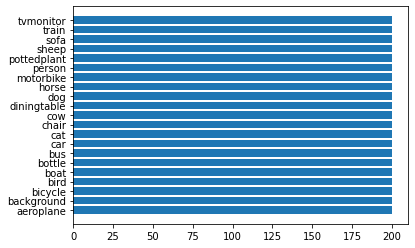

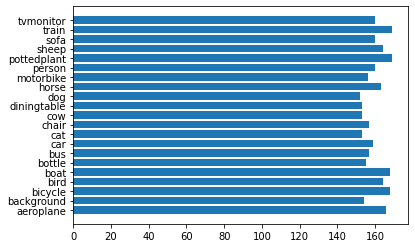

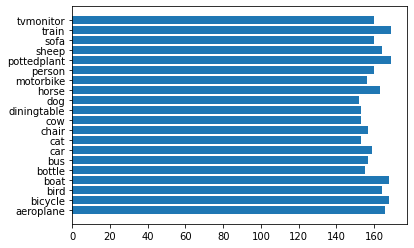

In [8]:
def draw_labels_in_y(y_train):
    names = []
    for y in y_train:
        index = np.argmax(y)
        if(index == 20): names.append("background")
        else: names.append(labels[index])

    unique, counts = np.unique(names, return_counts=True)

    # for i in range(len(unique)):
    #     print(f"{unique[i]}: {counts[i]}")

    plt.barh(range(len(unique)),counts)
    plt.yticks(range(len(unique)),unique)
    plt.show()

# draw_labels_in_y(y_train)
draw_labels_in_y(y_small)
draw_labels_in_y(Y_train)
draw_labels_in_y(y_train_without_bg)


car


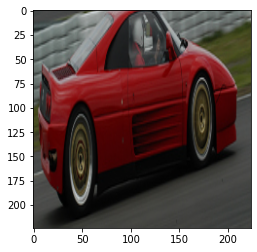

In [ ]:
import matplotlib.pyplot as plt

i = np.random.randint(len(Y_train))
img = np.load("data/training_dataset/x_train/"+X_train[i])
plt.imshow(img)
label_id = np.where(Y_train[i] == 1)[0][0]
if(label_id == 20): print('background')
else: print(labels[label_id])

In [ ]:
# ranges = [(0,2500),(2500,5000),(5000,7500),(7500,10000),(12500,15000),(15000,df_anno.shape[0])]
# save_dir = "data/training_dataset"

# for i, ran in enumerate(ranges[2:]):
#     print(f"Between {ran[0]} and {ran[1]}")
#     x_train, y_train, info = extract_data_for_training(ran[0],ran[1])
#     save_array(x_train, os.path.join(save_dir,f"cv2__{ran[0]}-{ran[1]}__{len(y_train)}__X.npy"))
#     save_array(y_train, os.path.join(save_dir,f"cv2__{ran[0]}-{ran[1]}__{len(y_train)}__Y.npy"))
#     print()
#     x_train = None
#     y_train = None
#     info = None

Between 5000 and 7500
 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□] 99% 0:41 31906
Between 7500 and 10000
 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□] 98% 0:40 31581
Between 12500 and 15000
 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□] 99% 0:40 21647
Between 15000 and 17125
 [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■□□□□□] 95% 2:39 15921


## Create feature extractor model

#### Hyperparameters

In [107]:
learning_rate = 1e-4
batch_size = 16
epochs = 50

# nb_class = len(y_small[0])
# print(nb_class)
nb_class= 21
x_shape = (224,224,3)

#### Use VGG16 model and change last layer 

In [108]:
import numpy as np

from keras import models
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten, Dropout
from keras.losses import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from numba import cuda 
device = cuda.get_current_device()
print(device)

<CUDA device 0 'b'NVIDIA GeForce GTX 1650 Ti''>


In [8]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, verbose=1, mode='max', min_lr=1e-5)
filepath="models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

baseModel = VGG16(weights='imagenet', include_top=False, input_shape=x_shape)

# Freezer les couches du VGG16
for layer in baseModel.layers[:15]:
	layer.trainable = False
	
x = baseModel.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(nb_class, activation='softmax')(x)

modelvgg = models.Model(inputs=baseModel.input, outputs=x)
modelvgg.summary()

opt = Adam(learning_rate=learning_rate)
modelvgg.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### unuse code

In [ ]:
# x_train = np.array([])
# y_train = np.array([])
# save_dir = "data/training_dataset"

# for i, dataset in enumerate(os.listdir(save_dir)):
#     print('\r',f"{i}/{len(os.listdir(save_dir))}", "{:.0f} GiB".format((x_train.size * x_train.itemsize)/1e9),end="")
    
#     if(dataset[-5] == "X"):
#         tmp = np.load(os.path.join(save_dir,dataset))
#         if(len(x_train) == 0):
#             x_train = tmp
#         else:
#             x_train = np.concatenate((x_train, tmp))
#     elif(dataset[-5] == "Y"):
#         tmp = np.load(os.path.join(save_dir,dataset))
#         if(len(y_train) == 0):
#             y_train = tmp
#         else:
#             y_train = np.concatenate((y_train, tmp))

 8/9 142 GiB

In [ ]:
# np.save("data/training_dataset/x_train__2500-15000__118030.npy", x_train)

In [ ]:
# np.save("data/training_dataset/y_train__2500-15000__118030.npy", y_train)

In [ ]:
# x_train_1 = np.load("cv2__0-2500__30889__X.npy")
# y_train_1 = np.load("cv2__0-2500__30889__Y.npy")

# x_train_2 = np.load("cv2__2500-5000__31616__X.npy")
# y_train_2 = np.load("cv2__2500-5000__31616__Y.npy")

# x_train_3 = np.load("cv2__5000-7500__32330__X.npy")
# y_train_3 = np.load("cv2__5000-7500__32330__Y.npy")

# x_train_4 = np.load("cv2__7500-10000__32159__X.npy")
# y_train_4 = np.load("cv2__7500-10000__32159__Y.npy")

In [ ]:
# x_train = np.concatenate((x_train_1, x_train_2, x_tr))
# y_train = np.concatenate((y_train_1, y_train_2, y_train_3, y_train_4))

## Training

In [126]:
from tensorflow.keras.utils import Sequence
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class CustomDataGenerator(Sequence):
    # VGG_MEANS = tf.reshape(tf.constant([123.68, 116.78, 103.94]), [1, 1, 3])

    def __init__(self, x, y, batch_size, x_shape, nb_class, data_dir):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.data_dir = data_dir
        self.x_shape = x_shape
        self.nb_class = nb_class
        self.on_epoch_end()

    def __len__(self):
        "Take all batches in each iteration"
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size, len(self.x))]
                
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))

    def __data_generation(self, indexes):
        X = np.empty((batch_size, *x_shape))
        Y = np.empty((batch_size, nb_class))

        for i, index in enumerate(indexes):
            X[i] = preprocess_input(np.load(self.data_dir+'/'+self.x[index])*255)
            Y[i] = self.y[index]
        
        return X, Y


In [127]:
trainData = CustomDataGenerator(
    x=X_train, 
    y=Y_train, 
    batch_size=batch_size, 
    x_shape=x_shape, 
    nb_class=nb_class, 
    data_dir="data/training_dataset/x_train")
    
valData = CustomDataGenerator(
    x=X_val, 
    y=Y_val, 
    batch_size=batch_size, 
    x_shape=x_shape, 
    nb_class=nb_class, 
    data_dir="data/training_dataset/x_train")

testData = CustomDataGenerator(
    x=X_test,
    y=Y_test,
    batch_size=batch_size,
    x_shape=x_shape,
    nb_class=nb_class,
    data_dir="data/training_dataset/x_train"
)

In [11]:
history = modelvgg.fit(trainData, validation_data=valData, epochs=epochs, callbacks=[lr_reduce, earlyStopping, checkpoint]) # earlyStopping

Epoch 1/50
2499/2499 [==============================] - ETA: 0s - loss: 1.1613 - accuracy: 0.6705
Epoch 00001: val_accuracy improved from -inf to 0.87688, saving model to weights-improvement-01-0.88.hdf5
2499/2499 [==============================] - 586s 227ms/step - loss: 1.1613 - accuracy: 0.6705 - val_loss: 0.4123 - val_accuracy: 0.8769 - lr: 1.0000e-04
Epoch 2/50
2499/2499 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.8775
Epoch 00002: val_accuracy improved from 0.87688 to 0.89640, saving model to weights-improvement-02-0.90.hdf5
2499/2499 [==============================] - 557s 223ms/step - loss: 0.4338 - accuracy: 0.8775 - val_loss: 0.3703 - val_accuracy: 0.8964 - lr: 1.0000e-04
Epoch 3/50
2499/2499 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.9158
Epoch 00003: val_accuracy improved from 0.89640 to 0.91723, saving model to weights-improvement-03-0.92.hdf5
2499/2499 [==============================] - 562s 225ms/step - loss: 0.298

modelvgg.save('rcnn_model_save.h5')

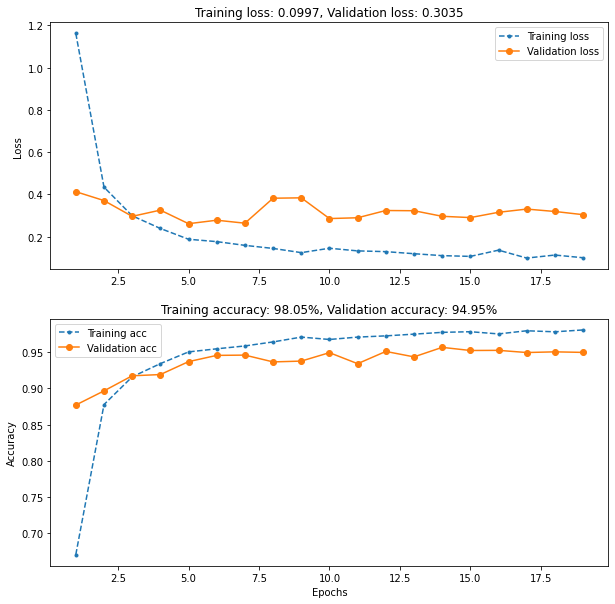

In [12]:
helpers.plot_loss_acc(history)

## Test model

In [117]:
from keras import models

modelvgg = models.load_model('weights-improvement-14-0.96.hdf5')

In [118]:
y_predict = modelvgg.predict(testData)

In [119]:
y_predict_max = []
for y in y_predict:
    tmp = np.zeros(21)
    tmp[np.argmax(y)] = 1
    y_predict_max.append(tmp)
y_predict_max = np.array(y_predict_max)

In [147]:
y_test = Y_test[:len(y_predict)]

In [145]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict_max, average="macro")

0.9706206258645595

In [146]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict_max, average="macro", multi_class="ovr")

0.9849589581011244

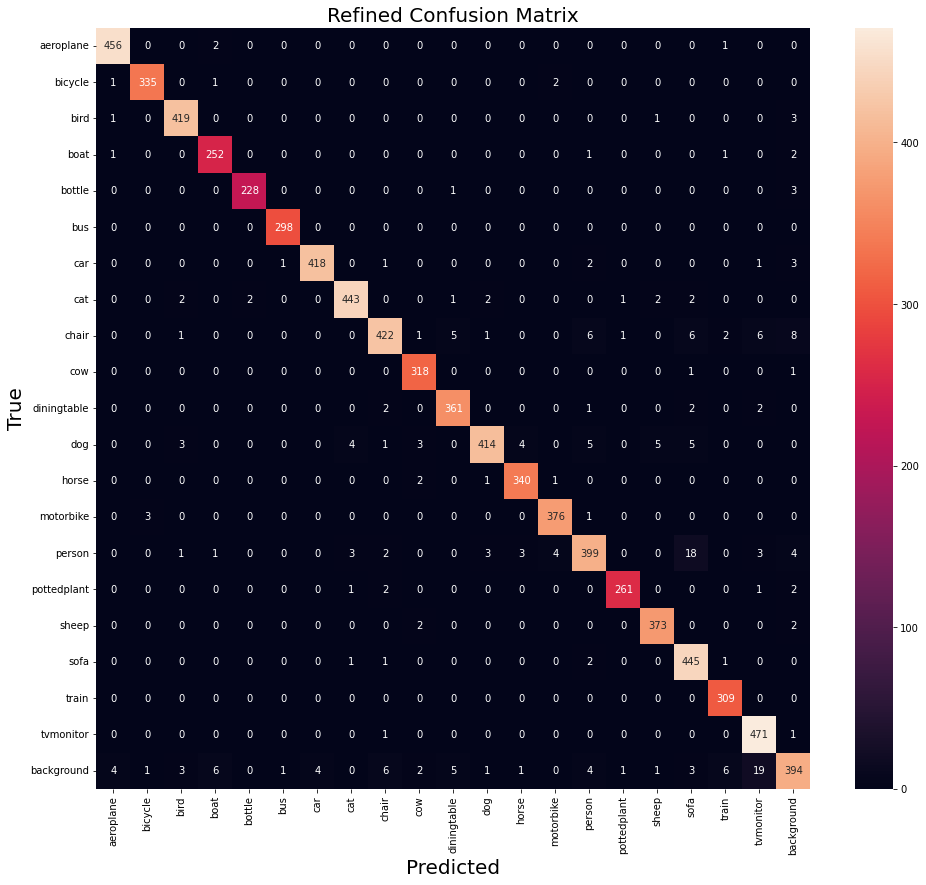

In [153]:
import helpers
from importlib import reload
reload(helpers)
helpers.plot_multiclass_heatmap(y_test, y_predict, labels)

## Use model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import models

In [ ]:
colors = ['yellow', 'blue', 'red', 'green', 'purple']

In [2]:
import cv2
import imageio
cv2.setUseOptimized(True)
ss2 = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [324]:
ran_img = df_anno.iloc[np.random.randint(df_anno.shape[0])]
img = get_image_from_anno(row=ran_img)[0]
annot = get_true_detection_from_anno(row=ran_img)
print(tuple(annot))

({'name': 'person', 'rect': (267.0, 6.0, 349.0, 250.0)},)


In [325]:
ss2.setBaseImage(img)
ss2.switchToSelectiveSearchFast()
rects = list(ss2.process())
rects_copy = np.copy(rects) 
len(rects)

2204

In [ ]:
rects = rects_copy

In [33]:
modelvgg = models.load_model('weights-improvement-14-0.96.hdf5')

In [326]:
batch_size = 16
img_shape = (224, 224, 3)
bbox = []
predictions = []

nb_rect = len(rects)
while len(rects) > 0:
    rect_batch = []
    abatch = []
    while len(abatch) < batch_size and len(rects) > 0:
        r = rects.pop(0)
        r[2] += r[0]
        r[3] += r[1]
        rect_batch.append(r)
        abatch.append(preprocess_input(get_wrapped_extracted_bbox(img, tuple(r), img_shape)*255))

    abatch = np.array(abatch)
    
    predict = modelvgg.predict(abatch)

    for i in range(len(predict)):
        if max(predict[i]) > 0.7 and np.argmax(predict[i]) != 20:
            predictions.append({'name': labels[np.argmax(predict[i])], 'rect': tuple(rect_batch[i]), 'proba': max(predict[i])})
    
    print('\r', len(rects), end="")



 0

In [327]:
len(predictions)

507

horse: 0.9845615029335022


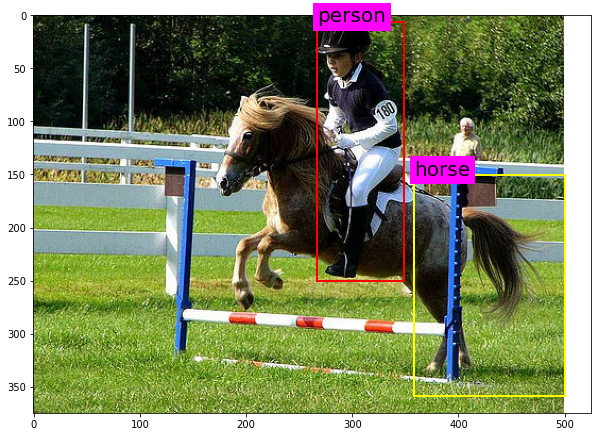

In [335]:
plt.figure(figsize=(10,12))
plt.imshow(img)
pred = np.random.choice(predictions)
print(f'{pred["name"]}: {pred["proba"]}')
helpers.plt_rectangle(plt, *pred['rect'], label=pred['name'])
for anno in annot:
    helpers.plt_rectangle(plt, *anno['rect'], color="red", label=anno['name'])

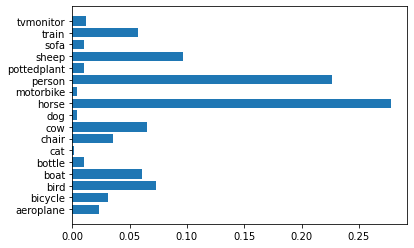

In [336]:
names = [pred['name'] for pred in predictions]

unique, counts = np.unique(names, return_counts=True)

norm_counts = [count/sum(counts) for count in counts]

plt.barh(range(len(unique)),norm_counts)
plt.yticks(range(len(unique)),unique)
plt.show()

In [337]:
label_to_keep = [ name for name, count in zip(unique, norm_counts) if count > 0.1]
predictions_restricted = [ pred for pred in predictions if pred['name'] in label_to_keep]
print(tuple(label_to_keep))
print(len(predictions_restricted), len(predictions))

('horse', 'person')
256 507


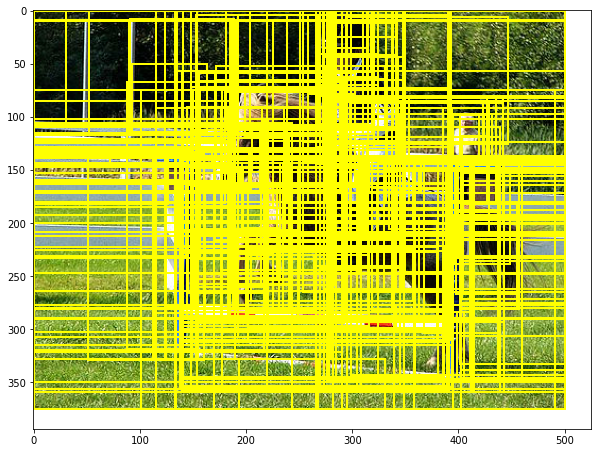

In [338]:
plt.figure(figsize=(10,12))
plt.imshow(img)
for pred in predictions:
    helpers.plt_rectangle(plt,*pred['rect'])
plt.show()

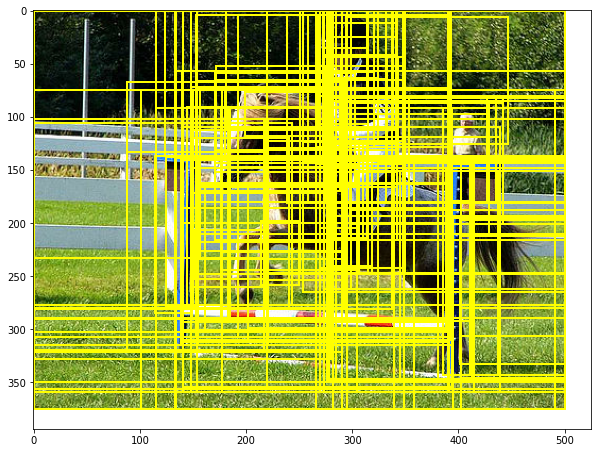

In [339]:
plt.figure(figsize=(10,12))
plt.imshow(img)
for pred in predictions_restricted:
    helpers.plt_rectangle(plt,*pred['rect'])
plt.show()

In [250]:
from tensorflow.image import non_max_suppression

In [341]:
max_output_size = 2
iou_threshold = 0.45
score_threshold = 0.25

main_boxes = []
for label in label_to_keep:
    main_box = non_max_suppression(
        boxes= [pred['rect'] for pred in predictions if pred['name'] == label],
        scores= [pred['proba'] for pred in predictions if pred['name'] == label], 
        max_output_size=max_output_size, 
        iou_threshold=iou_threshold, 
        score_threshold=score_threshold)
    for box in main_box:
        main_boxes.append({'label': label, 'box': predictions[box]['rect']})

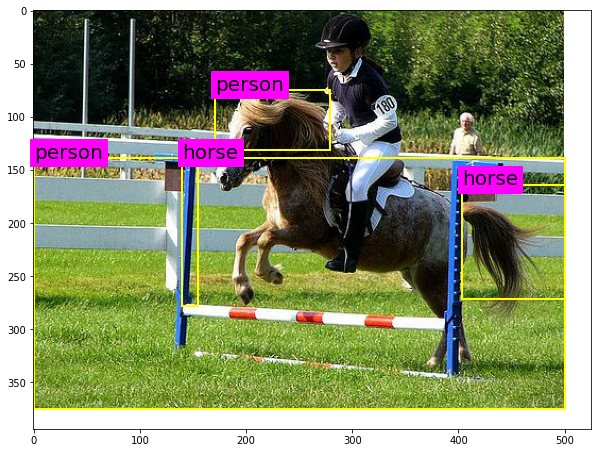

In [342]:
plt.figure(figsize=(10,12))
plt.imshow(img)
for res in main_boxes:
    helpers.plt_rectangle(plt,*res['box'], label=res['label'])

cifar-10